# Spiral-Distributed Data Classification

### Note
This notebook is adapted from https://github.com/Atcold/pytorch-Deep-Learning/blob/master/04-spiral_classification.ipynb

### Required Python Packages
- `numpy`
- `torch`
- `matplotlib`

Run the following cell to install the packages.

In [ ]:
# package install
!pip install "numpy>=1.22"
!pip install "torch>=1.9"
!pip install "matplotlib>=3.5"

In [2]:
import math
import random

import numpy as np
import torch
from IPython import display
from matplotlib import pyplot as plt
from torch import nn, optim

In [4]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(["dark_background", "bmh"])
    plt.rc("axes", facecolor="k")
    plt.rc("figure", facecolor="k")
    plt.rc("figure", figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis("square")
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True:
        plt.axis("equal")
    plt.axis("off")

    _m, _c = 0, ".15"
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

In [4]:
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
_ = torch.manual_seed(seed)

In [5]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = (
        torch.linspace(
            # When t = 0
            (2 * math.pi / C) * (c),
            # When t = 1
            (2 * math.pi / C) * (2 + c),
            N,
        )
        + torch.randn(N) * 0.2
    )

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


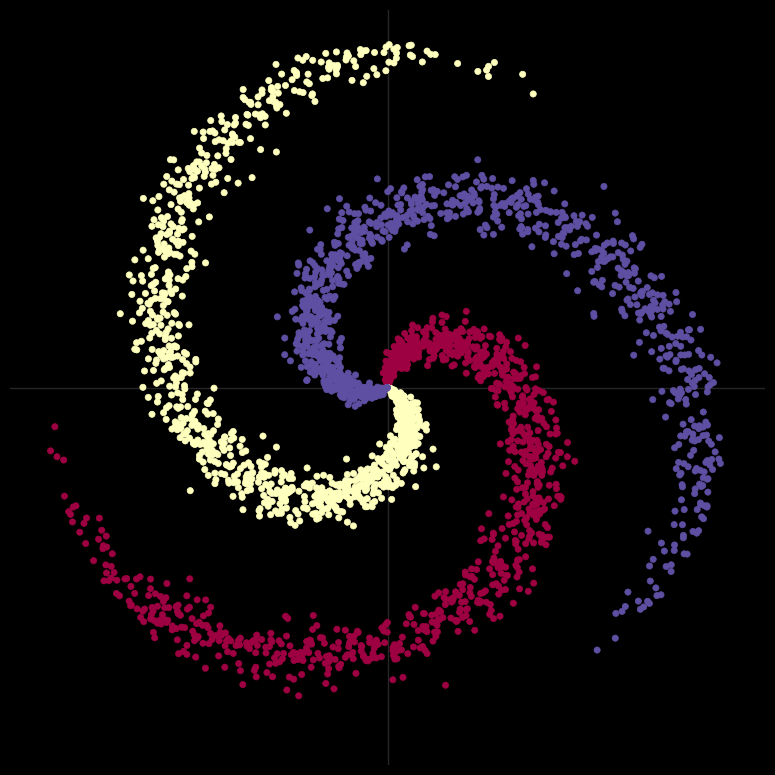

In [6]:
# visualise the data
plot_data(X, y)

### Linear model

In [7]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


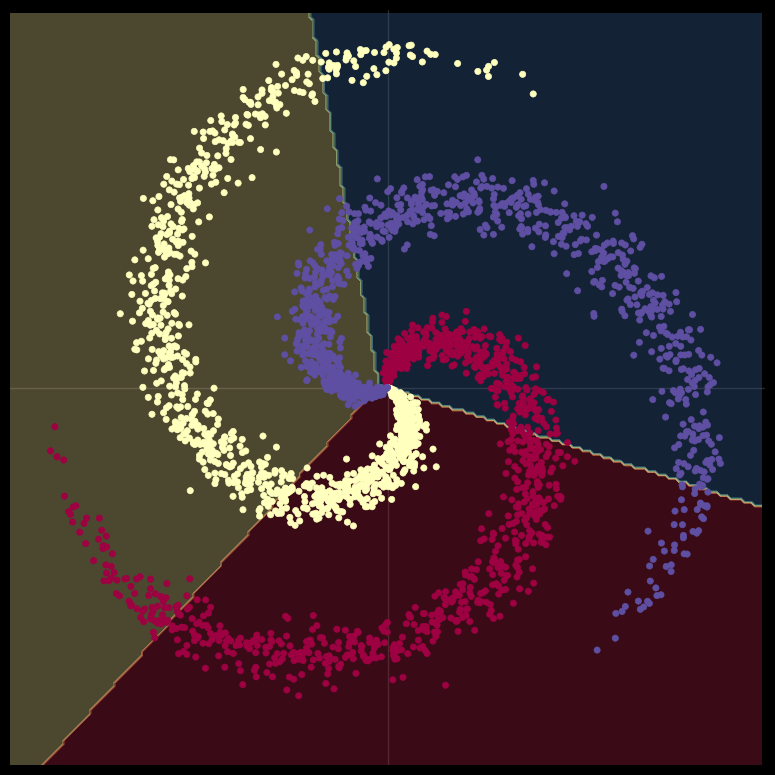

In [8]:
# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(nn.Linear(D, H), nn.Linear(H, C))
linear_model.to(device)  # Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)  # built-in L2

# Training
for t in range(1000):

    # Feed forward to get the logits
    y_pred = linear_model(X)

    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)

    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()

    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params.
    loss.backward()

    # Update params
    optimizer.step()

# Plot trained model
print(linear_model)
plot_model(X, y, linear_model)

del loss
del score
del predicted
del y_pred

### Two-layered network

In [2]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


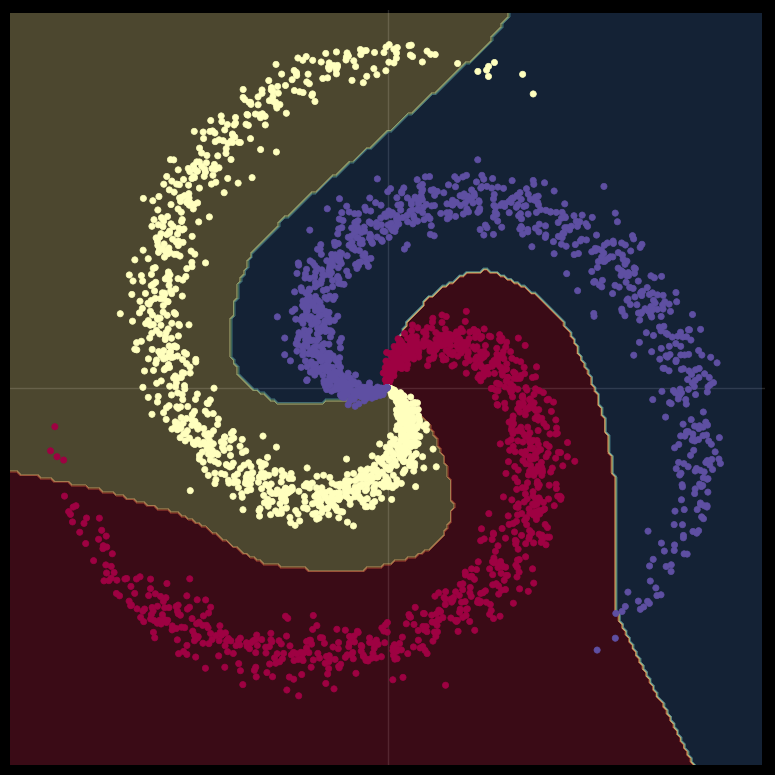

In [8]:
# nn package to create our linear model
# each Linear module has a weight and bias

two_layer_model = nn.Sequential(nn.Linear(D, H), nn.ReLU(), nn.Linear(H, C))
two_layer_model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)  # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):

    # Feed forward to get the logits
    y_pred = two_layer_model(X)

    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)

    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()

    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params.
    loss.backward()

    # Update params
    optimizer.step()

print(two_layer_model)
plot_model(X, y, two_layer_model)